In this notebook, we will explore Airbnb dataset for Istanbul. Dataset is compiled by Airbnb on 28 April,2020.

In [0]:
import numpy as np
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
#importing csv data to pandas dataframe
df = pd.read_csv('listings.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (43,61,62,94) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
#these are the columns that we will use in our analysis
useful_columns_list = ['id','host_id','host_is_superhost', 'neighbourhood_cleansed','zipcode',
               'bathrooms','bedrooms','bed_type','amenities','square_feet',
               'price','number_of_reviews', 'review_scores_rating', 'review_scores_location']



In [0]:
df = df[useful_columns_list]

In [5]:
#getting basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23438 entries, 0 to 23437
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      23438 non-null  int64  
 1   host_id                 23438 non-null  int64  
 2   host_is_superhost       23435 non-null  object 
 3   neighbourhood_cleansed  23438 non-null  object 
 4   zipcode                 21037 non-null  object 
 5   bathrooms               23357 non-null  float64
 6   bedrooms                23294 non-null  float64
 7   bed_type                23438 non-null  object 
 8   amenities               23438 non-null  object 
 9   square_feet             234 non-null    float64
 10  price                   23438 non-null  object 
 11  number_of_reviews       23438 non-null  int64  
 12  review_scores_rating    10997 non-null  float64
 13  review_scores_location  10984 non-null  float64
dtypes: float64(5), int64(3), object(6)
mem

In [6]:
#checking some samples
df.head()

,id,host_id,host_is_superhost,neighbourhood_cleansed,zipcode,bathrooms,bedrooms,bed_type,amenities,square_feet,price,number_of_reviews,review_scores_rating,review_scores_location
0,4826,6603,f,Uskudar,34684,1.0,0.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Smoking ...",700.0,$734.00,1,100.0,NaN
1,20815,78838,f,Besiktas,34345,1.0,2.0,Real Bed,"{TV,""Cable TV"",""Air conditioning"",Kitchen,""Fre...",NaN,$832.00,41,90.0,10.0
2,27271,117026,f,Beyoglu,34433,1.0,1.0,Real Bed,"{TV,Internet,Wifi,Kitchen,""Paid parking off pr...",NaN,$230.00,13,98.0,10.0
3,28277,121607,f,Sisli,34373,1.0,1.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,E...",753.0,$747.00,0,NaN,NaN
4,28318,121721,f,Sariyer,34398,1.0,2.0,Real Bed,"{""Cable TV"",Internet,Wifi,Kitchen,""Free parkin...",700.0,$837.00,0,NaN,NaN


'amenities' column has information that could be useful in predicting 'review_scores_rating'. Therefore, we should create features using this column.

In [0]:
def amenities_to_features(x):

  x['TV'] = True if 'TV' in x['amenities'] else False
  x['Kitchen'] = True if 'Kitchen' in x['amenities'] else False
  x['Paid parking off premises'] = True if 'Paid parking off premises' in x['amenities'] else False
  x['Heating'] = True if 'Heating' in x['amenities'] else False
  x['Washer'] = True if 'Washer' in x['amenities'] else False
  x['Air Conditioning'] = True if 'Air conditioning' in x['amenities'] else False
  x['Free Parking on premises'] = True if 'Free parking on premises' in x['amenities'] else False
  x['Breakfast'] = True if 'Breakfast' in x['amenities'] else False
  x['Patio or balcony'] = True if 'Patio or balcony' in x['amenities'] else False
  x['Luggage dropoff allowed'] = True if 'Luggage dropoff allowed' in x['amenities'] else False
  x['Shampoo'] = True if 'Shampoo' in x['amenities'] else False
  x['Free street parking'] = True if 'Free street parking' in x['amenities'] else False


  return x



In [8]:
pd.set_option('display.max_colwidth', None)
df.head().apply(amenities_to_features, axis=1)

,id,host_id,host_is_superhost,neighbourhood_cleansed,zipcode,bathrooms,bedrooms,bed_type,amenities,square_feet,price,number_of_reviews,review_scores_rating,review_scores_location,TV,Kitchen,Paid parking off premises,Heating,Washer,Air Conditioning,Free Parking on premises,Breakfast,Patio or balcony,Luggage dropoff allowed,Shampoo,Free street parking
0,4826,6603,f,Uskudar,34684,1.0,0.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Smoking allowed"",""Pets allowed"",Breakfast,Heating,""Family/kid friendly"",Washer,Dryer,Essentials}",700.0,$734.00,1,100.0,NaN,True,True,False,True,True,False,False,True,False,False,False,False
1,20815,78838,f,Besiktas,34345,1.0,2.0,Real Bed,"{TV,""Cable TV"",""Air conditioning"",Kitchen,""Free parking on premises"",""Pets allowed"",Heating,""Family/kid friendly"",Washer,Essentials,Shampoo,""24-hour check-in"",Hangers,""Hair dryer"",Iron,""Laptop friendly workspace"",""Host greets you""}",NaN,$832.00,41,90.0,10.0,True,True,False,True,True,True,True,False,False,False,True,False
2,27271,117026,f,Beyoglu,34433,1.0,1.0,Real Bed,"{TV,Internet,Wifi,Kitchen,""Paid parking off premises"",Doorman,""Buzzer/wireless intercom"",Heating,""Family/kid friendly"",Washer,""First aid kit"",""Fire extinguisher"",Essentials,Shampoo,Hangers,""Hair dryer"",Iron,""Laptop friendly workspace"",""translation missing: en.hosting_amenity_50"",""Hot water"",""Bed linens"",""Extra pillows and blankets"",""Long term stays allowed"",""Host greets you""}",NaN,$230.00,13,98.0,10.0,True,True,True,True,True,False,False,False,False,False,True,False
3,28277,121607,f,Sisli,34373,1.0,1.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,Elevator,Heating,""Family/kid friendly"",Washer,Dryer,Essentials,Hangers,""Hair dryer"",Iron,""Hot water"",""Bed linens"",Microwave,Refrigerator,""Patio or balcony"",""Long term stays allowed""}",753.0,$747.00,0,NaN,NaN,True,True,False,True,True,True,False,False,True,False,False,False
4,28318,121721,f,Sariyer,34398,1.0,2.0,Real Bed,"{""Cable TV"",Internet,Wifi,Kitchen,""Free parking on premises"",Doorman,""Buzzer/wireless intercom"",Heating,""Family/kid friendly"",Washer,Dryer,""First aid kit"",""Fire extinguisher"",Essentials,Shampoo}",700.0,$837.00,0,NaN,NaN,True,True,False,True,True,False,True,False,False,False,True,False


In [0]:
df = df.apply(amenities_to_features, axis=1)

In [0]:
df = df.drop(columns=['amenities'])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23438 entries, 0 to 23437
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         23438 non-null  int64  
 1   host_id                    23438 non-null  int64  
 2   host_is_superhost          23435 non-null  object 
 3   neighbourhood_cleansed     23438 non-null  object 
 4   zipcode                    21037 non-null  object 
 5   bathrooms                  23357 non-null  float64
 6   bedrooms                   23294 non-null  float64
 7   bed_type                   23438 non-null  object 
 8   square_feet                234 non-null    float64
 9   price                      23438 non-null  object 
 10  number_of_reviews          23438 non-null  int64  
 11  review_scores_rating       10997 non-null  float64
 12  review_scores_location     10984 non-null  float64
 13  TV                         23438 non-null  boo

It is good practice to check the type of data in each column. For example, here we expect price column to be float but we see that it is object type (here it is string). So, we should clean the price column. First removing the '$' and ' , ' from the string, and then converting the resulting string to the float. 

In [0]:
df['price'] = df['price'].str.replace(',', '')
df['price'] = df['price'].str.replace('$', '')
df['price'] = df['price'].astype('float')

We should also encode categorical variables to numeric values because RandomForestRegressor will not work with strings. We can use unique values for each categories in each column. 

In [13]:
print('Unique values for neighbourhood_cleansed:', df['neighbourhood_cleansed'].unique(), '\n')
print('Unique values for host_is_superhost:', df['host_is_superhost'].unique(), '\n')
print('Unique values for zipcode:', df['zipcode'].unique(), '\n')
print('Unique values for bed_type:', df['bed_type'].unique(), '\n')

Unique values for neighbourhood_cleansed: ['Uskudar' 'Besiktas' 'Beyoglu' 'Sisli' 'Sariyer' 'Fatih' 'Kadikoy'
 'Kagithane' 'Adalar' 'Maltepe' 'Esenyurt' 'Beykoz' 'Basaksehir'
 'Bahcelievler' 'Bagcilar' 'Silivri' 'Beylikduzu' 'Umraniye' 'Sile'
 'Cekmekoy' 'Kucukcekmece' 'Sancaktepe' 'Bakirkoy' 'Tuzla' 'Pendik'
 'Atasehir' 'Kartal' 'Sultangazi' 'Gaziosmanpasa' 'Buyukcekmece' 'Eyup'
 'Zeytinburnu' 'Catalca' 'Avcilar' 'Gungoren' 'Bayrampasa' 'Esenler'
 'Sultanbeyli' 'Arnavutkoy'] 

Unique values for host_is_superhost: ['f' 't' nan] 

Unique values for zipcode: ['34684' '34345' '34433' '34373' '34398' '34445' '34457' '34365' '34425'
 '34290' nan '34437' '34674' '34330' '34200' '34440' '34400' '34250'
 '34427' '34430' '34122' '34744' '34724' '34710' '34970' '34420' '34453'
 '34387' '34672' '34840' '34093' '34306' '34394' '34421' '34381' '34050'
 '34716' '34726' '34360' '34435' '34363' '34347' '34664' '34353' '34240'
 '34470' '34668' '34375' '34349' '34500' '34734' '34718' '34340' '34342'
 '3

As we see, zipcode data is a little messy. Some zipcode values are string and some of them are float. Additionally, there are some string entries that are not zipcode. Finally, some of the numeric values are not valid zipcodes. Zipcodes in Istanbul are between 34000 and 35000. 

In [0]:
def clean_neighbourhood_cleansed(input_series):

  output_list = [map_func_neighbourhood_cleansed(item) for item in input_series]
  
  return pd.Series(output_list, index=input_series.index)


def map_func_neighbourhood_cleansed(x):

  map_dict = {'Uskudar':1, 'Besiktas':2, 'Beyoglu':3, 'Sisli':4, 'Sariyer':5, 'Fatih':6, 'Kadikoy':7,
 'Kagithane':8, 'Adalar':9, 'Maltepe':10, 'Esenyurt':11, 'Beykoz':12, 'Basaksehir':13,
 'Bahcelievler':14, 'Bagcilar':15, 'Silivri':16, 'Beylikduzu':17, 'Umraniye':18, 'Sile':19,
 'Cekmekoy':20, 'Kucukcekmece':21, 'Sancaktepe':22, 'Bakirkoy':23, 'Tuzla':24, 'Pendik':25,
 'Atasehir':26, 'Kartal':27, 'Sultangazi':28, 'Gaziosmanpasa':29, 'Buyukcekmece':30, 'Eyup':31,
 'Zeytinburnu':32, 'Catalca':33, 'Avcilar':34, 'Gungoren':35, 'Bayrampasa':36, 'Esenler':37,
 'Sultanbeyli':38, 'Arnavutkoy':39}

  try:
    return map_dict[x]

  except:
    return -1


def clean_zipcode(input_series):

  output_list = [map_func_zipcode(item) for item in input_series]
  
  return pd.Series(output_list, index=input_series.index)


def map_func_zipcode(x):

  try:
    y = int(x)

    if y < 34000 or y > 35000:
      return 0

    return y

  except:
    return 0




def clean_host_is_superhost(input_series):

  output_list = [map_func_host_is_super_host(item) for item in input_series]
  
  return pd.Series(output_list, index=input_series.index)


def map_func_host_is_super_host(x):

  if x == 't':
    return 1

  else:
    return 0



def clean_bed_type(input_series):

  output_list = [map_func_bed_type(item) for item in input_series]
  
  return pd.Series(output_list, index=input_series.index)


def map_func_bed_type(x):

  if x == 'Real Bed':
    return 0
  elif x == 'Pull-out Sofa':
    return 1
  elif x == 'Couch':
    return 2
  elif x == 'Airbed':
    return 3
  elif x == 'Futon':
    return 4
  else:
    return -1


In [0]:
def encode_categoricals(pd_series):


  if pd_series.name == 'zipcode':
    return clean_zipcode(pd_series)

  elif pd_series.name == 'host_is_superhost':
    return clean_host_is_superhost(pd_series)

  elif pd_series.name == 'bed_type':
    return clean_bed_type(pd_series)
  
  elif pd_series.name == 'neighbourhood_cleansed':
    return clean_neighbourhood_cleansed(pd_series)

  else:
    return pd_series 
  

In [0]:
df = df.apply(encode_categoricals, axis=0)

In [17]:
df.head()

,id,host_id,host_is_superhost,neighbourhood_cleansed,zipcode,bathrooms,bedrooms,bed_type,square_feet,price,number_of_reviews,review_scores_rating,review_scores_location,TV,Kitchen,Paid parking off premises,Heating,Washer,Air Conditioning,Free Parking on premises,Breakfast,Patio or balcony,Luggage dropoff allowed,Shampoo,Free street parking
0,4826,6603,0,1,34684,1.0,0.0,0,700.0,734.0,1,100.0,NaN,True,True,False,True,True,False,False,True,False,False,False,False
1,20815,78838,0,2,34345,1.0,2.0,0,NaN,832.0,41,90.0,10.0,True,True,False,True,True,True,True,False,False,False,True,False
2,27271,117026,0,3,34433,1.0,1.0,0,NaN,230.0,13,98.0,10.0,True,True,True,True,True,False,False,False,False,False,True,False
3,28277,121607,0,4,34373,1.0,1.0,0,753.0,747.0,0,NaN,NaN,True,True,False,True,True,True,False,False,True,False,False,False
4,28318,121721,0,5,34398,1.0,2.0,0,700.0,837.0,0,NaN,NaN,True,True,False,True,True,False,True,False,False,False,True,False


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23438 entries, 0 to 23437
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         23438 non-null  int64  
 1   host_id                    23438 non-null  int64  
 2   host_is_superhost          23438 non-null  int64  
 3   neighbourhood_cleansed     23438 non-null  int64  
 4   zipcode                    23438 non-null  int64  
 5   bathrooms                  23357 non-null  float64
 6   bedrooms                   23294 non-null  float64
 7   bed_type                   23438 non-null  int64  
 8   square_feet                234 non-null    float64
 9   price                      23438 non-null  float64
 10  number_of_reviews          23438 non-null  int64  
 11  review_scores_rating       10997 non-null  float64
 12  review_scores_location     10984 non-null  float64
 13  TV                         23438 non-null  boo

Now, the data in all columns are in expected type. If we look to 'number_of_reviews', we see that most of the accommodations got very few reviews. If we do our analysis with the samples having many reviews, we obtain more reliable results. 

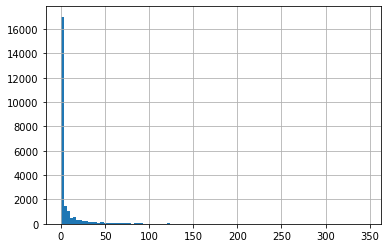

In [19]:
df['number_of_reviews'].hist(bins=100)
plt.show()

Setting a threshold to filter the hosts that get enough reviews.

In [0]:
threshold_for_review = 10
df_review_threshold = df[df['number_of_reviews']>threshold_for_review]

We should drop some of the columns that will not be useful in prediction of the 'review_scores_rating'. We keep 'host_id' column to use it in train-validation splitting as group variable.

In [0]:
df_review_threshold = df_review_threshold.drop(columns=['id','host_is_superhost','number_of_reviews','review_scores_location'])

In [22]:
df_review_threshold.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3918 entries, 1 to 21813
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   host_id                    3918 non-null   int64  
 1   neighbourhood_cleansed     3918 non-null   int64  
 2   zipcode                    3918 non-null   int64  
 3   bathrooms                  3915 non-null   float64
 4   bedrooms                   3916 non-null   float64
 5   bed_type                   3918 non-null   int64  
 6   square_feet                106 non-null    float64
 7   price                      3918 non-null   float64
 8   review_scores_rating       3918 non-null   float64
 9   TV                         3918 non-null   bool   
 10  Kitchen                    3918 non-null   bool   
 11  Paid parking off premises  3918 non-null   bool   
 12  Heating                    3918 non-null   bool   
 13  Washer                     3918 non-null   bool

We see that in 'square feet' column, data is present only for small subset of the samples. We can drop that column.

In [0]:
df_review_threshold = df_review_threshold.drop(columns='square_feet')

In addition, we should also take care of the missing values for other columns. We can impute constant values to the columns of 'bathrooms' and 'bedrooms'. 

In [0]:
df_review_threshold.fillna(-1, inplace=True)

Another handy method in pandas for exploring a dataset is 'describe' method. When we used that method, we observe abnormal values for maximum number of bathrooms and bedrooms as 11. Additionally, we saw maximum price is $69,912. That is abnormally high for renting a place in Istanbul for a night. However, these outliers will not dramatically effect our prediction analysis because we will use tree based model.

In [25]:
df_review_threshold.describe()

,host_id,neighbourhood_cleansed,zipcode,bathrooms,bedrooms,bed_type,price,review_scores_rating
count,3.918000e+03,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000
mean,8.973662e+07,5.247575,31861.121491,1.143441,1.375702,0.008678,377.695253,93.423175
std,9.536694e+07,5.222833,8977.470143,0.513635,0.895763,0.129516,1181.959816,5.208161
min,7.883800e+04,1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,67.000000
25%,1.162866e+07,3.000000,34200.000000,1.000000,1.000000,0.000000,168.000000,91.000000
50%,4.197629e+07,3.000000,34421.000000,1.000000,1.000000,0.000000,272.000000,95.000000
75%,1.779758e+08,6.000000,34435.000000,1.000000,2.000000,0.000000,427.000000,97.000000
max,3.357793e+08,39.000000,34990.000000,11.000000,11.000000,4.000000,69912.000000,100.000000


Now we can split the data as train and test sets. We need to be careful about dependencies in the data in splitting the dataset. In our case, accommodations might be dependent if they belong to the same host. If we, don't take this dependencies into consideration, we might have over-optimistic models. For this reason, we will use GroupShuffleSplit method in sklearn. This method will ensure us to have accommodations belonging to a same host will appear either only in train or test set.   

In [26]:
print("The number of accommodations in the list:", pd.unique(df['id']).shape[0])
print("The number of hosts in the list:", pd.unique(df['host_id']).shape[0])

The number of accommodations in the list: 23438
The number of hosts in the list: 14234


In [0]:
#initializing GroupShuffleSplit class
gss_for_test = GroupShuffleSplit(n_splits=2, train_size=.8, random_state=42)

#generating train and test indices
train_inds, test_inds = next(gss_for_test.split(df_review_threshold, groups=df_review_threshold['host_id']))

#obtaining train and test dataframes
df_train, df_test = df_review_threshold.iloc[train_inds], df_review_threshold.iloc[test_inds]

Finally, we finished our data preprocessing steps and now we can work on our predictive model. We can try to tune some of the hyperparameters. We will search optimal hyperparameter values in randomized search manner. 

In [0]:
# Setting candidates for some hyperparameters, these hyperparameters are the most important ones for randomforest regressor. 
# They can help reducing overfitting if tuned properly.
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(1,10, num=10)]
n_estimators = [200]

We initialize our cross validation splitter, regressor and class that will search for optimal hyperparameters.

In [0]:
gss = GroupShuffleSplit(n_splits=3, random_state=42).split(df_train, groups=df_train['host_id'])
parameters = {'max_features':max_features, 'max_depth':max_depth, 'n_estimators':n_estimators, 'min_samples_leaf':min_samples_leaf}
regr = RandomForestRegressor(random_state=42)
rand_search = RandomizedSearchCV(estimator=regr, param_distributions=parameters, cv=gss, n_jobs=-1, n_iter=100)

We should drop 'host_id' column because it is not a useful predictor for review scores and it might create some bias in analysis.

In [0]:
df_train = df_train.drop(columns=['host_id'])
df_test = df_test.drop(columns=['host_id'])

It is good to check the columns before feeding our dataframe to the model training pipeline.

In [31]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3163 entries, 1 to 21813
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   neighbourhood_cleansed     3163 non-null   int64  
 1   zipcode                    3163 non-null   int64  
 2   bathrooms                  3163 non-null   float64
 3   bedrooms                   3163 non-null   float64
 4   bed_type                   3163 non-null   int64  
 5   price                      3163 non-null   float64
 6   review_scores_rating       3163 non-null   float64
 7   TV                         3163 non-null   bool   
 8   Kitchen                    3163 non-null   bool   
 9   Paid parking off premises  3163 non-null   bool   
 10  Heating                    3163 non-null   bool   
 11  Washer                     3163 non-null   bool   
 12  Air Conditioning           3163 non-null   bool   
 13  Free Parking on premises   3163 non-null   bool

In [32]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 755 entries, 22 to 21683
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   neighbourhood_cleansed     755 non-null    int64  
 1   zipcode                    755 non-null    int64  
 2   bathrooms                  755 non-null    float64
 3   bedrooms                   755 non-null    float64
 4   bed_type                   755 non-null    int64  
 5   price                      755 non-null    float64
 6   review_scores_rating       755 non-null    float64
 7   TV                         755 non-null    bool   
 8   Kitchen                    755 non-null    bool   
 9   Paid parking off premises  755 non-null    bool   
 10  Heating                    755 non-null    bool   
 11  Washer                     755 non-null    bool   
 12  Air Conditioning           755 non-null    bool   
 13  Free Parking on premises   755 non-null    bool

In [33]:
rand_search.fit(df_train.drop(columns=['review_scores_rating']), df_train['review_scores_rating'])

RandomizedSearchCV(cv=<generator object BaseShuffleSplit.split at 0x7f2f1c5a7258>,
                   error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fractio...
                              

We trained our model and now we can examine the results. Here we will look to predictions in test set and RMSE value for this predictions. 

In [34]:
#best hyperparameter setting giving the least mean squared error in cross validation set.
rand_search.best_params_

{'max_depth': 90,
 'max_features': 'sqrt',
 'min_samples_leaf': 9,
 'n_estimators': 200}

In [0]:
#predicting the 'review_scores_rating' in test set using the best model. 
pred_review_scores_rating = rand_search.predict(df_test.drop(columns=['review_scores_rating']))

In [36]:
mse = mean_squared_error(df_test['review_scores_rating'], pred_review_scores_rating)
print('Root mean squared error for the test set is ', sqrt(mse))

Root mean squared error for the test set is  4.617274497057054


We can visualize the difference between ground truths and predictions. If the histogram of the difference has a gaussian distribution with zero mean and small variance, it indicates that our model has good performance.

In [0]:
predictions = pd.Series(data=pred_review_scores_rating,index=df_test['review_scores_rating'].index)
ground_truth = df_test['review_scores_rating']

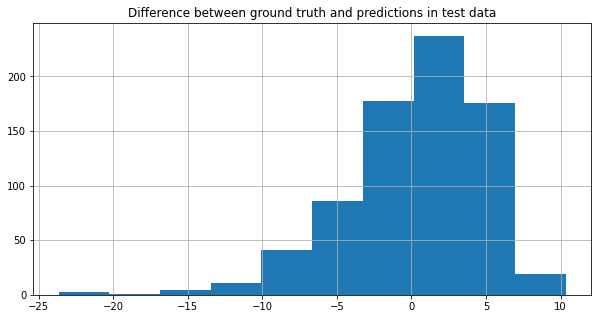

In [38]:
plt.figure(figsize=(10,5))
(ground_truth - predictions).hist()
plt.title('Difference between ground truth and predictions in test data')
plt.show()

Latly, we examine which features are important in predicting review scores. We see that price and zipcode are the most important features for predicting review scores. These two features have highest cardinality. This fact might inflate the importance of the features. 
Surprisingly, bed type is the least important feature for our model.

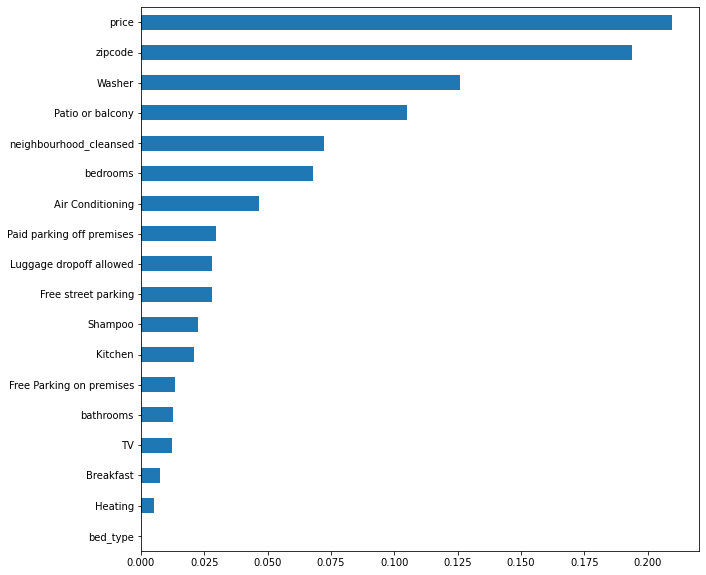

In [39]:
feature_importances = rand_search.best_estimator_.feature_importances_
feature_importances = pd.Series(feature_importances, index=df_test.drop(columns=['review_scores_rating']).columns)
plt.figure(figsize=(10,10))
feature_importances.sort_values().plot(kind='barh')
plt.show()


We repeat the predictive analysis by dummy encoding 'zipcode' and 'neighbourhood_cleansed' columns. In this way, we can see each location's importance in predicting review scores rating.

In [0]:
df_review_threshold_dummies = pd.get_dummies(df_review_threshold ,columns=['zipcode','neighbourhood_cleansed'])

#initializing GroupShuffleSplit class
gss_for_test = GroupShuffleSplit(n_splits=2, train_size=.8, random_state=42)

#generating train and test indices
train_inds, test_inds = next(gss_for_test.split(df_review_threshold_dummies, groups=df_review_threshold_dummies['host_id']))

#obtaining train and test dataframes
df_train_dummies, df_test_dummies = df_review_threshold_dummies.iloc[train_inds], df_review_threshold_dummies.iloc[test_inds]

In [0]:
gss = GroupShuffleSplit(n_splits=3, random_state=42).split(df_train_dummies, groups=df_train_dummies['host_id'])
parameters = {'max_features':max_features, 'max_depth':max_depth, 'n_estimators':n_estimators, 'min_samples_leaf':min_samples_leaf}
regr = RandomForestRegressor(random_state=42)
rand_search = RandomizedSearchCV(estimator=regr, param_distributions=parameters, cv=gss, n_jobs=-1, n_iter=100)

In [0]:
df_train_dummies = df_train_dummies.drop(columns=['host_id'])
df_test_dummies = df_test_dummies.drop(columns=['host_id'])

In [43]:
rand_search.fit(df_train_dummies.drop(columns=['review_scores_rating']), df_train_dummies['review_scores_rating'])

RandomizedSearchCV(cv=<generator object BaseShuffleSplit.split at 0x7f2f1b02eca8>,
                   error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fractio...
                              

In [44]:
#best hyperparameter setting giving the least mean squared error in cross validation set.
rand_search.best_params_

{'max_depth': 100,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'n_estimators': 200}

In [0]:
#predicting the 'review_scores_rating' in test set using the best model. 
pred_review_scores_rating = rand_search.predict(df_test_dummies.drop(columns=['review_scores_rating']))

In [46]:
mse = mean_squared_error(df_test_dummies['review_scores_rating'], pred_review_scores_rating)
print('Root mean squared error for the test set is ', sqrt(mse))

Root mean squared error for the test set is  4.565074422793783


In [0]:
predictions = pd.Series(data=pred_review_scores_rating,index=df_test_dummies['review_scores_rating'].index)
ground_truth = df_test_dummies['review_scores_rating']

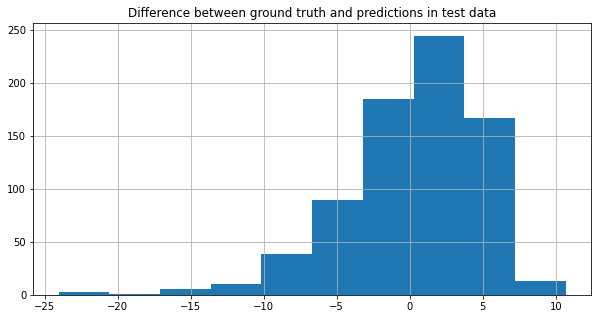

In [48]:
plt.figure(figsize=(10,5))
(ground_truth - predictions).hist()
plt.title('Difference between ground truth and predictions in test data')
plt.show()

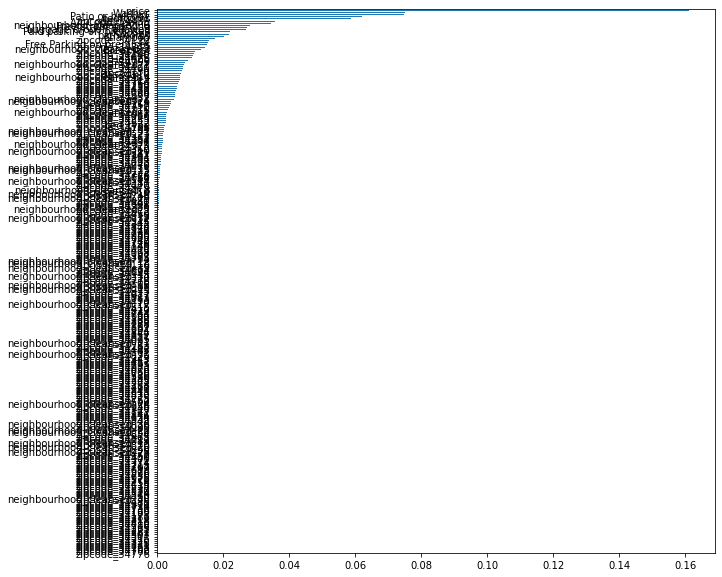

In [49]:
feature_importances = rand_search.best_estimator_.feature_importances_
feature_importances = pd.Series(feature_importances, index=df_test_dummies.drop(columns=['review_scores_rating']).columns)
plt.figure(figsize=(10,10))
feature_importances.sort_values().plot(kind='barh')
plt.show()

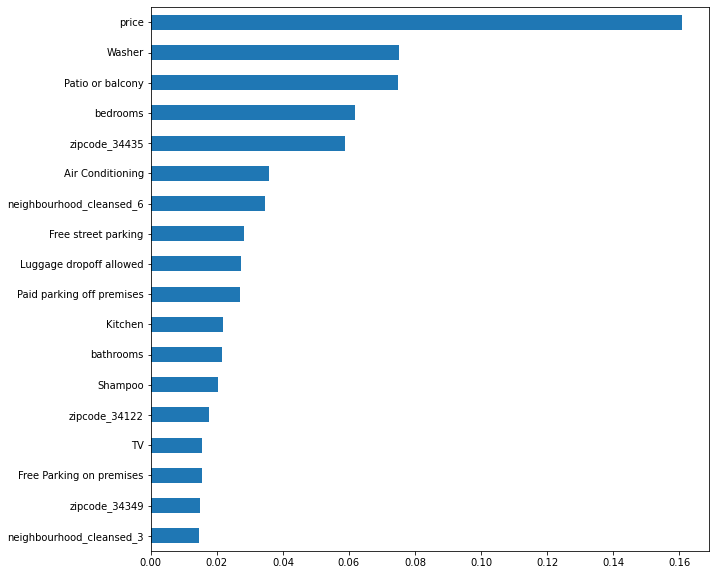

In [50]:
feature_importances = rand_search.best_estimator_.feature_importances_
feature_importances = pd.Series(feature_importances, index=df_test_dummies.drop(columns=['review_scores_rating']).columns)
plt.figure(figsize=(10,10))
feature_importances.nlargest(18).sort_values().plot(kind='barh')
plt.show()